


Epoch 1/200

55/55 - 8s - loss: 0.0086 - 8s/epoch - 151ms/step
Epoch 2/200
55/55 - 0s - loss: 0.0074 - 312ms/epoch - 6ms/step
Epoch 3/200
55/55 - 0s - loss: 0.0074 - 312ms/epoch - 6ms/step
Epoch 4/200
55/55 - 0s - loss: 0.0073 - 308ms/epoch - 6ms/step
Epoch 5/200
55/55 - 0s - loss: 0.0073 - 321ms/epoch - 6ms/step
Epoch 6/200
55/55 - 0s - loss: 0.0072 - 304ms/epoch - 6ms/step
Epoch 7/200
55/55 - 0s - loss: 0.0073 - 317ms/epoch - 6ms/step
Epoch 8/200
55/55 - 0s - loss: 0.0072 - 328ms/epoch - 6ms/step
Epoch 9/200
55/55 - 0s - loss: 0.0072 - 312ms/epoch - 6ms/step
Epoch 10/200
55/55 - 0s - loss: 0.0072 - 313ms/epoch - 6ms/step
Epoch 11/200
55/55 - 0s - loss: 0.0072 - 317ms/epoch - 6ms/step
Epoch 12/200
55/55 - 0s - loss: 0.0072 - 313ms/epoch - 6ms/step
Epoch 13/200
55/55 - 0s - loss: 0.0071 - 310ms/epoch - 6ms/step
Epoch 14/200
55/55 - 0s - loss: 0.0072 - 317ms/epoch - 6ms/step
Epoch 15/200
55/55 - 0s - loss: 0.0072 - 312ms/epoch - 6ms/step
Epoch 16/200
55/55 - 0s - loss: 0.0072 - 320ms

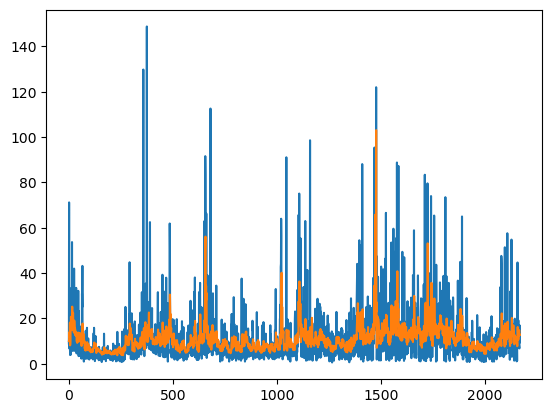

C:\Users\rutvi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error for NOx-H24: 157.2581243831108
CPU times: total: 1min 14s
Wall time: 1min 25s


C:\Users\rutvi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1]:
%%time
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Load your dataset
# Assuming your dataset is stored in a CSV file
df = pd.read_csv('cleaned_data.csv')

# Specify the correct O3 column name
NOxcolumn = 'NOx-H24'  # Update this with the correct column name for O3


# Function to train LSTM model for O3 pollutant column
def train_lstm_model(data, column_name):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[[column_name]])

    # Prepare data for LSTM
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    look_back = 10  # Increase the look_back value for capturing more temporal patterns
    train_size = int(len(scaled_data) * 0.8)
    train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Reshape the data for LSTM input
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Build LSTM model with more complexity
    model = Sequential()
    model.add(LSTM(100, input_shape=(1, look_back), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=200, batch_size=32, verbose=2)

    # Make predictions using LSTM model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions to original scale
    trainPredict = scaler.inverse_transform(np.reshape(trainPredict, (trainPredict.shape[0], 1)))
    trainY = scaler.inverse_transform(np.reshape(trainY, (len(trainY), 1)))
    testPredict = scaler.inverse_transform(np.reshape(testPredict, (testPredict.shape[0], 1)))
    testY = scaler.inverse_transform(np.reshape(testY, (len(testY), 1)))

    # Plot the results
    plt.plot(np.concatenate([trainY, testY]))
    plt.plot(np.concatenate([trainPredict, testPredict]))
    plt.show()

    # Train ARIMA model on the residuals
    residuals = trainY - trainPredict
    model_arima = ARIMA(residuals, order=(5, 2, 1))
    model_arima_fit = model_arima.fit()

    # Forecast using ARIMA
    arima_forecast = model_arima_fit.forecast(steps=len(testY))[0]

    # Calculate the final prediction by adding LSTM prediction and ARIMA forecast
    final_prediction = testPredict + arima_forecast

    # Evaluate the model
    mse = mean_squared_error(testY, final_prediction)
    print(f'Mean Squared Error for {column_name}: {mse}')

# Train LSTM and ARIMA for O3 pollutant column
train_lstm_model(df, NOxcolumn)
